In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import warnings
warnings.filterwarnings("ignore")

In [ ]:
returns = pd.read_pickle("../Data/returns.pkl")
returns

In [ ]:
returns = returns.iloc[1:]

In [ ]:
# dropping columns with all NaN
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

In [ ]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [ ]:
t = pd.to_datetime("2020-02-25")

get_investable(t, 80)

In [ ]:
# Converts investable dataframe into 3D tensor for input into RNN fitting
# Eg. if investable_df has shape (52, 635), it is converted to a numpy array of shape (52, 1, 635)

def formatX(investable_df):
    train_values = []
    # Iterates through each day in investable df and appends feature values to train_values
    for i in range(len(investable_df.index)):
        train_values.append(investable_df.iloc[i].values)
    train_values = np.array(train_values) # converts to numpy array
    train_values = np.reshape(train_values, (train_values.shape[0], 1, train_values.shape[1])) # reshapes to 3-dimensional
    return train_values

In [ ]:
formatX(get_investable(t, 80))

In [ ]:
# Formats output for a stock as a np array
# Takes in a stock, a date, and a number of rows to look back on and formats the output values as a numpy array
# Eg. formatY(stockX, Feb.25, 80) outputs the returns for stockX starting from 80 days before Feb.25 up to Feb.25

def formatY(stock, t, n_rows):
    t_index = returns.index.get_loc(t)
    return returns[stock].iloc[t_index - n_rows:t_index + 1].shift(-1).iloc[:-1].values[::-1]

In [ ]:
formatY("916328", t, 80)

In [ ]:
# Creating a Simple RNN for an inputted stock

def get_model(stock, investable_df):
    # Converts features and output values to a 3D tensor and numpy array respectively
    convertedX = formatX(investable_df)
    t_index = returns.index.get_loc(investable_df.index[0])
    t = returns.index[t_index + 1]
    convertedY = formatY(stock, t, len(investable_df.index))
    
    # Builds model with three layers (SimpleRNN, Dense, Dense)
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(convertedX.shape[1], convertedX.shape[2]), activation="relu"))
    model.add(Dense(8, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    
    # Fits model on formatted inputs and outputs
    history = model.fit(convertedX, convertedY, validation_split=0.2, epochs=100, batch_size=16, verbose=0)
    history
    
    return model, history

In [ ]:
# Predicts stock price at a given date
import datetime

# Number of days to look back at when training model
look_back = 80

def pred_date(stock, date):
    investable = get_investable(date, look_back + 1)
    
    # Checking for invalid inputs
    if stock not in investable.columns:
        print(stock + " is not in the investable universe")
        return
    if investable.shape[0] == 0:
        print("Investable universe is empty")
        return
    
    ''' investable.iloc[0:1] is the first row of the investable df 
    (i.e. the row we're using to predict the stock's return at time date) '''
    convertedX = formatX(investable.iloc[0:1])
    
    ''' We train the model on the day before date (the parameter) so that the date we're predicting
    for is not included in the training set'''
    model = get_model(stock, investable.iloc[1:])[0]
    
    return model.predict(convertedX)[0, 0]

In [ ]:
pred_date("916328", t)

In [ ]:
# Predicts returns for all stocks in the investable universe at a given date
def pred_date_all(date):
    investable = get_investable(date, look_back)
    df = pd.DataFrame()
    stocks = []
    predictions = []
    count = 0 # used to keep track of progress when running function
    for stock in investable.columns:
        stocks.append(stock)
        predictions.append(pred_date(stock, date))
        count += 1
        percent = count / len(investable.columns)
        print(str(percent * 100) + "% ")
    df["stock"] = stocks
    df["pred_" + date.strftime("%Y-%m-%d")] = predictions
    return df

In [ ]:
pred_t = pred_date_all(t)

In [ ]:
pred_t

In [ ]:
# Takes in output of pred_date_all and returns a portfolio and expected returns
def get_portfolio(predictions_df, num_stocks):
    pred_col = predictions_df.columns[-1]
    sorted_df = predictions_df.sort_values(by=pred_col, ascending=False)
    top = sorted_df.head(num_stocks)
    bot = sorted_df.tail(num_stocks)
    returns = top[pred_col].mean() - bot[pred_col].mean()
    return top, bot, returns

In [ ]:
t = pd.to_datetime("2021-05-28")
test_size = 40
look_back = 240
investable = get_investable(t, look_back + test_size)

tts = investable.index[test_size]
delta = datetime.timedelta(days=1)

model = get_model("916328", investable.loc[tts:])[0]

In [ ]:
df = pd.DataFrame()
predictions = []
actuals = []
dates = []
for date in investable.index[:test_size]:
    convertedX = formatX(investable.loc[[date]])
    prediction = model.predict(convertedX)[0, 0]
    actual = investable.loc[date, "916328"].item()
    predictions.append(prediction)
    actuals = np.append(actuals, actual)
    dates.append(date)
df["predictions"] = np.array(predictions)
df["actuals"] = actuals
df["date"] = dates
df.set_index("date", inplace=True)
df

In [ ]:
sns.lineplot(data=df, x="date", y="actuals")
sns.lineplot(data=df, x="date", y="predictions")
plt.xticks(rotation=45)

In [ ]:
# metrics for sample stock
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MSE: " + str(mean_squared_error(y_true=df.actuals, y_pred=df.predictions)))
print("MAE: " + str(mean_absolute_error(y_true=df.actuals, y_pred=df.predictions)))
print("R2: " + str(r2_score(y_true=df.actuals, y_pred=df.predictions)))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_metrics(look_back):
    t = pd.to_datetime("2021-05-28")
    test_size = int(0.1 * look_back)
    investable = get_investable(t, test_size + look_back)
    actuals = investable.head(test_size)
    
    df_dict = {}
    
    count = 1
    for stock in investable.columns:
        predictions = []
        model = get_model(stock, investable.iloc[test_size:])[0]
        for day in range(test_size - 1, -1, -1):
            formattedX = formatX(investable.iloc[[day]])
            predictions.append(model.predict(formattedX)[0, 0])
        df_dict[stock] = predictions
        if count % 10 == 0:
            print(count, end=" ")
        count += 1
        
    dates = []
    for day in investable.index[:test_size][::-1]:
        dates.append(day)
    df_dict["date"] = dates
    
    df = pd.DataFrame(df_dict)
    df.set_index("date", inplace=True)
    df.sort_index(ascending=False, inplace=True)
    
    # Metrics
    MSE = mean_squared_error(y_true=actuals, y_pred=df)
    MAE = mean_absolute_error(y_true=actuals, y_pred=df)
    R2 = r2_score(y_true=actuals, y_pred=df)
    
    return df, actuals, {"MSE": MSE, "MAE": MAE, "R2": R2}

In [ ]:
metrics_240 = get_metrics(240)

In [ ]:
print("MSE: " + str(metrics_240[2]["MSE"]))
print("MAE: " + str(metrics_240[2]["MAE"]))
print("R2: " + str(metrics_240[2]["R2"]))

In [ ]:
def get_returns(df):
    new_df = pd.DataFrame()
    new_df["date"] = df.index
    new_df.set_index("date", inplace=True)
    pred_returns = []
    actual_returns = []
    dates = []
    long_returns = []
    short_returns = []
    for date in df.index:
        portfolio = get_portfolio(df.loc[[date]].T.reset_index(), 5)
        top = portfolio[0]
        bot = portfolio[1]
        pred_return = portfolio[2]
        top_stocks = top["index"].values
        bot_stocks = bot["index"].values
        
        long_return = returns.loc[date, top_stocks].mean()
        short_return = -returns.loc[date, bot_stocks].mean()
        actual_return = long_return + short_return 
        
        pred_returns.append(pred_return)
        actual_returns.append(actual_return)
        long_returns.append(long_return)
        short_returns.append(short_return)
        dates.append(date)
        
    df = pd.DataFrame({"date": dates, 
                       "actual_returns": actual_returns,
                       "pred_returns": pred_returns,
                       "long_returns": long_returns,
                       "short_returns": short_returns})
    
    df.set_index("date", inplace=True)
    
    return df

In [ ]:
get_returns(metrics_240[0])

In [ ]:
returns_240 = get_returns(metrics_240[0])

new_df = pd.DataFrame()
for col in returns_240.columns:
    df = pd.DataFrame()
    df["date"] = returns_240.index
    df["return_val"] = returns_240[col].values
    df["return_type"] = col.replace("_returns", "")
    new_df = pd.concat([new_df, df])
    
new_df.set_index("date", inplace=True)
new_df

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=new_df, x="date", y="return_val", hue="return_type")
plt.xticks(rotation=45)
plt.axhline(0, ls="--")

In [ ]:
def get_all_models(t, look_back):
    models = {}
    investable = get_investable(t, look_back)
    for stock in investable.columns:
        model = get_model(stock, investable)[0]
        models[stock] = model
    return models

In [ ]:
t = pd.to_datetime("2021-05-28")
look_back = 160

models = get_all_models(t, look_back)
models

In [ ]:
def pred_future(models, days):
    investable = get_investable(t, 1)
    stocks = investable.columns
    df = returns.loc[[t], stocks]
    next_day = t
    for day in range(1, days + 1):
        features = df.iloc[[-1]]
        formatted = formatX(features)
        next_day += datetime.timedelta(days=1)
        if next_day.weekday() == 5: # if saturday, skip to monday
            next_day += datetime.timedelta(days=2)
        predictions = {"date": [next_day]}
        for stock in stocks:
            model = models[stock]
            predictions[stock] = [model.predict(formatted)[0, 0]]
        predictions = pd.DataFrame(predictions).set_index("date")
        df = pd.concat([df, predictions])
    return df

In [ ]:
pred_future(models, 30)

In [117]:
# Recall: get_model function

# Creating a Simple RNN for an inputted stock
def get_model(stock, investable_df):
    # Converts features and output values to a 3D tensor and numpy array respectively
    convertedX = formatX(investable_df)
    t_index = returns.index.get_loc(investable_df.index[0])
    t = returns.index[t_index + 1]
    convertedY = formatY(stock, t, len(investable_df.index))
    
    # Builds model with three layers (SimpleRNN, Dense, Dense)
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(convertedX.shape[1], convertedX.shape[2]), activation="relu"))
    model.add(Dense(8, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
    
    # Fits model on formatted inputs and outputs
    history = model.fit(convertedX, convertedY, validation_split=0.2, epochs=100, batch_size=16, verbose=0)
    history
    
    return model, history

In [110]:
# increase test_size and look_back
t = pd.to_datetime("2021-05-28")
test_size = 40
look_back = 240
investable = get_investable(t, look_back + test_size)

# get data to plot
history = get_model("916328", investable.loc[tts:])[1]
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


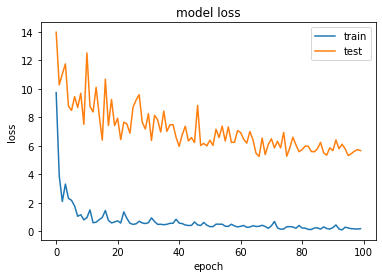

In [101]:
# plot the loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

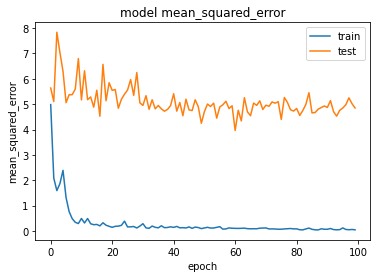

In [108]:
# plot the mean_squared_error history
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

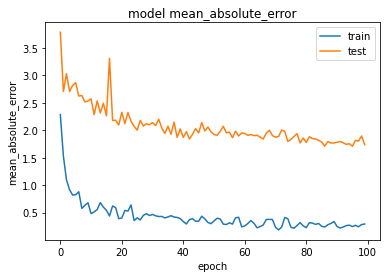

In [111]:
# plot the mean_absolute_error history
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# Try to improve test loss
'''
- Increase test_size and look_back
- Increase the number of units in the first/second layer
    - Only if data set is large enough
'''

In [120]:
# increase test_size and look_back
t = pd.to_datetime("2021-05-28")
test_size = 40 #was 40
look_back = 365 #was 240
investable = get_investable(t, look_back + test_size)

# get data to plot
history = get_model("916328", investable.loc[tts:])[1]
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


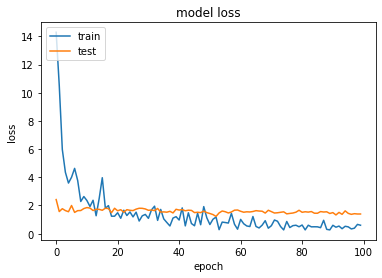

In [121]:
# plot the loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
# increase test_size and look_back
t = pd.to_datetime("2021-05-28")
test_size = 40 #was 40
look_back = 730 #was 240
investable = get_investable(t, look_back + test_size)

# get data to plot
history = get_model("916328", investable.loc[tts:])[1]
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


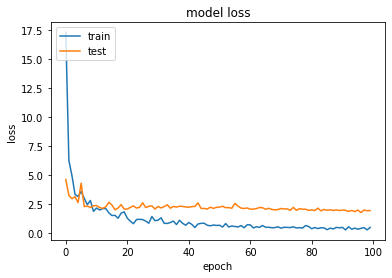

In [119]:
# plot the loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()